In [249]:
# Load the rpy2 extension to run R code in the notebook
%load_ext rpy2.ipython
import warnings
# Filter out warnings from the dplyr package
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [250]:
%%R
# Load the dplyr library for data manipulation
library(dplyr)
# Load the ggplot2 library for data visualization
library(ggplot2)
# Read the raw data from the compas-scores-two-years.csv file into a dataframe
raw_data <- read.csv("./compas-scores-two-years.csv")
# Print the number of rows in the raw data
nrow(raw_data)

[1] 7214


In [251]:
%%R
# Select relevant columns from the raw data and filter the dataset
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count,
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>%
        # Filter for records where the number of days between screening and arrest is within 30 days
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        # Filter out records where the recidivism status is unknown (-1)
        filter(is_recid != -1) %>%
        # Filter out records with unknown charge degree ('O')
        filter(c_charge_degree != "O") %>%
        # Filter out records with missing score text ('N/A')
        filter(score_text != 'N/A')
# Print the number of rows in the filtered dataframe
nrow(df)

[1] 6172


In [252]:
%%R
# Calculate the length of stay in jail by subtracting the check-in date from the check-out date
df$length_of_stay <- as.numeric(as.Date(df$c_jail_out) - as.Date(df$c_jail_in))
# Calculate the correlation between the length of stay and the decile score
cor(df$length_of_stay, df$decile_score)

[1] 0.2073297


In [253]:
%%R
# Get a summary of the age_cat column
summary(df$age_cat)

   Length     Class      Mode 
     6172 character character 


In [254]:
%%R
# Get a summary of the race column
summary(df$race)

   Length     Class      Mode 
     6172 character character 


In [255]:
# Calculate and print the percentage distribution of defendants by race
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [256]:
%%R
# Create a cross-tabulation (contingency table) of sex and race
# This shows the breakdown of sex within each racial category
xtabs(~ sex + race, data=df)

        race
sex      African-American Asian Caucasian Hispanic Native American Other
  Female              549     2       482       82               2    58
  Male               2626    29      1621      427               9   285


In [257]:
# Calculate and print the percentage distribution of defendants by sex
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [258]:
%%R
# Count the number of defendants who recidivated within two years (two_year_recid == 1)
nrow(filter(df, two_year_recid == 1))

[1] 2809


In [259]:
%%R
# Calculate the percentage of defendants who recidivated within two years
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 45.51199


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/gridExtra_2.3.tar.gz'
Content type 'application/x-gzip' length 1062844 bytes (1.0 MB)
downloaded 1.0 MB


The downloaded source packages are in
	‘/tmp/Rtmpprmddf/downloaded_packages’


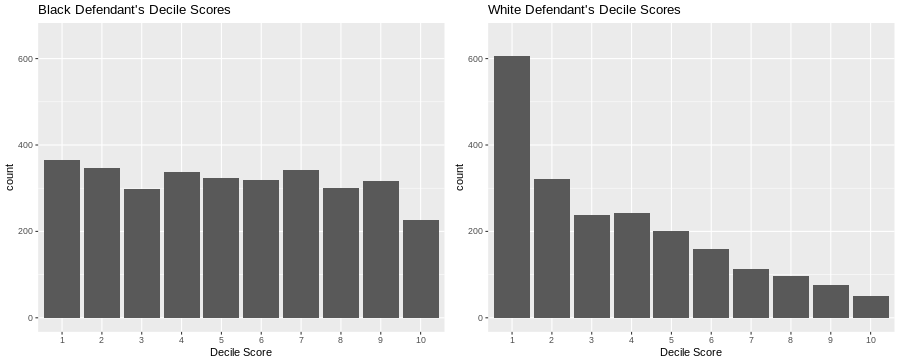

In [260]:
%%R -w 900 -h 363 -u px
# Install and load necessary packages for plotting
install.packages("gridExtra", repos = "http://cran.us.r-project.org")
library(grid)
library(gridExtra)
# Create a bar plot of decile scores for Black defendants
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(decile_score))) +
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("Black Defendant's Decile Scores")
# Create a bar plot of decile scores for White defendants
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(decile_score))) +
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("White Defendant's Decile Scores")
# Arrange and display the two plots side by side
grid.arrange(pblack, pwhite,  ncol = 2)

In [261]:
%%R
# Create a contingency table of decile score and race to show the distribution of scores across racial groups
xtabs(~ decile_score + race, data=df)

            race
decile_score African-American Asian Caucasian Hispanic Native American Other
          1               365    15       605      159               0   142
          2               346     4       321       89               2    60
          3               298     5       238       73               1    32
          4               337     0       243       47               0    39
          5               323     1       200       39               0    19
          6               318     2       160       27               2    20
          7               343     1       113       28               2     9
          8               301     2        96       14               0     7
          9               317     0        77       17               2     7
          10              227     1        50       16               2     8


In [262]:
%%R
# Data wrangling: Create factor variables and relevel them for the logistic regression model
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>% # Relevel age_factor with reference level 1
      mutate(race_factor = factor(race)) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>% # Relevel race_factor with reference level 3 (Caucasian)
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>% # Relevel gender_factor with reference level 2 (Male)
      mutate(score_factor = factor(score_text != "Low", labels = c("LowScore","HighScore"))) # Create a binary factor for High vs. Low scores
# Fit a logistic regression model to predict HighScore based on several predictors
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
# Summarize the logistic regression model results
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.52554    0.07851 -19.430  < 2e-16 ***
gender_factorFemale          0.22127    0.07951   2.783 0.005388 ** 
age_factorGreater than 45   -1.35563    0.09908 -13.682  < 2e-16 ***
age_factorLess than 25       1.30839    0.07593  17.232  < 2e-16 ***
race_factorAfrican-American  0.47721    0.06935   6.881 5.93e-12 ***
race_factorAsian            -0.25441    0.47821  -0.532 0.594717    
race_factorHispanic         -0.42839    0.12813  -3.344 0.000827 ***
race_factorNative American   1.39421    0.76612   1.820 0.068784 .  
race_factorOther            -0.82635    0.16208  -5.098 3.43e-07 ***
priors_count                 0.26895    0.01110  24.221  < 2e-16 ***
crime_factorM               -0.31124    0.06655  -4.677 2.9

In [263]:
%%R
# Calculate the baseline probability of having a HighScore (when all predictors are at reference level)
control <- exp(-1.52554) / (1 + exp(-1.52554))
# Calculate the odds ratio for African-American compared to the reference race (Caucasian)
# The formula used here calculates the adjusted odds ratio based on the logistic regression coefficient
exp(0.47721) / (1 - control + (control * exp(0.47721)))

[1] 1.452841


In [264]:
%%R
# Calculate the odds ratio for Female compared to the reference sex (Male)
# The formula used here calculates the adjusted odds ratio based on the logistic regression coefficient
exp(0.22127) / (1 - control + (control * exp(0.22127)))

[1] 1.194798


In [265]:
%%R
# Calculate the odds ratio for the age group "Less than 25" compared to the reference age group
# The formula used here calculates the adjusted odds ratio based on the logistic regression coefficient
exp(1.30839) / (1 - control + (control * exp(1.30839)))

[1] 2.49612
